# PyMem3DG Tutorial 4 - Visualize Output
`Cuncheng Zhu, Christopher T. Lee`

Mem3DG output the trajectory data using a combination of NetCDF and $\texttt{.ply}$ file. There are many ways to read the data. This tutorial provides a minimal set of functions from Python NetCDF and PyMem3DG to extact the data and visualize using Polyscope. 

In [3]:
import pymem3dg as dg
import pymem3dg.visual as dg_vis
import pymem3dg.read as dg_read

import numpy as np
import polyscope as ps
import netCDF4 as nc
import matplotlib.pyplot as plt

## NetCDF
Python netCDF4 library has conveient functions to extract a $\texttt{.nc}$ file. Here we provide an example of reading the file using data generated from tutorial 1.

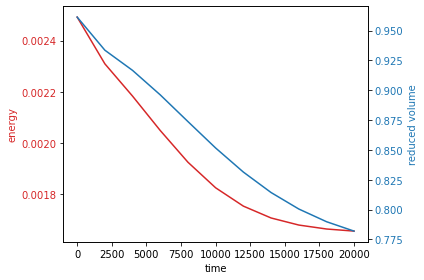

In [4]:
trajFile = 'output/tutorial1/biconcave/traj.nc'

p = dg.Parameters()
p.bending.Kbc = 8.22e-5
p.tension.Ksg = 0.1
p.tension.At = 12.4866
p.osmotic.isPreferredVolume = True
p.osmotic.Kv = 0.02
p.osmotic.Vt = 0.7 * 3.14 * 4 / 3


frameLim = (0, dg_read.sizeOf(trajFile))
frameNum = frameLim[1] - frameLim[0]
time = np.zeros(frameNum)
kineticEnergy = np.zeros(frameNum)
potentialEnergy = np.zeros(frameNum)
externalWork = np.zeros(frameNum)
totalEnergy = np.zeros(frameNum)
volume = np.zeros(frameNum)
for frame in range(frameNum):
    system = dg.System(
        trajFile,
        frame,
        p
    )
    system.initialize()
    time[frame] = system.time
    volume[frame] = system.volume
    system.computeTotalEnergy()
    energy = system.getEnergy()
    kineticEnergy[frame] = energy.kineticEnergy
    potentialEnergy[frame] = energy.potentialEnergy
    if frame != 0:
        externalWork[frame] = externalWork[
            frame - 1
        ] + system.computeIntegratedPower(time[frame] - time[frame - 1])
totalEnergy = potentialEnergy + kineticEnergy - externalWork
reducedVolume = volume / (3.14 * 4 / 3)

# plotting
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('time')
ax1.set_ylabel('energy', color=color)
ax1.plot(time, totalEnergy, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('reduced volume', color=color)
ax2.plot(time, reducedVolume, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()


Unlike the $\texttt{.ply}$ file that we will cover below, NetCDF file covers the full trajectory. Therefore, the first index of the resultant matrix is always the frame index.

## $\texttt{.ply}$
Mem3DG provide some wrapper functions of a C++ library Happly to help extracting data from $\texttt{.ply}$ file.

In [5]:
ply = 'output/tutorial4/out.ply'
face, vertex = dg.readMesh(ply)
print(dg.readData(ply))
print(dg.readData(ply, 'vertex'))
H = dg.readData(ply, 'vertex', 'mean_curvature')
Fb = dg.readData(ply, 'vertex', 'bending_force')

['face', 'gc_internal_vertex', 'gc_internal_halfedge', 'gc_internal_edge', 'gc_internal_face', 'gc_internal_bl', 'vertex']
['x', 'y', 'z', 'protein_density', 'mask', 'smoothing_mask', 'the_point', 'mean_curvature', 'gauss_curvature', 'spon_curvature', 'bending_force', 'capillary_force', 'line_tension_force', 'osmotic_force', 'external_force', 'physical_force', 'diffusion_potential', 'bending_potential', 'adsorption_potential', 'chemical_potential']


## Visualize using Polyscope
Details and functionalities of Polyscope is located at https://polyscope.run/py/

In [6]:
ps.init()
ps_mesh = ps.register_surface_mesh("RBC", vertex, face)
ps_mesh.add_scalar_quantity("mean_curvature", H, enabled=True)
ps_mesh.add_scalar_quantity("bending_force", Fb, enabled=True, vminmax=(-1e-5, 1e-5))
ps.set_up_dir("z_up")
ps.show()